In [7]:
# Comparing RO to INS data

import sys
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts")
sys.path.append("/Users/roberto/code/robust-me-scripts/scripts/config")
from figs import plot
import motion

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import pandas as pd
import os
from numpy import *

import module
import settings

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.titlepad'] = 20
plt.rcParams['axes.grid'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 16 # was 28

# text
plt.rc("font", family=settings.FONT_FAMILY)

module.set_sys_paths()

from mrg.logging import MonolithicDecoder
from mrg.adaptors.transform import PbSerialisedTransformToPython
from mrg.transform.conversions import se3_to_components, build_se3_transform

import numpy as np
from config.data import *

colour_ro = u'#d62728' #red
colour_spline = u'#1f77b4' #blue
colour_aux_1 = u'#ff7f0e' #orange
colour_aux_2 = u'#2ca02c' #green
colour_ins = 'black' #black

In [2]:
dataset_path = "/tmp/"
INS_relative_poses_path = dataset_path+"flattened_novatel_generated_poses.monolithic"

# INS - open monolithic and iterate frames
print("reading INS_relative_poses_path: " + INS_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    INS_relative_poses_path)

# iterate mono
INS_se3s = []
INS_timestamps = []

for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    INS_se3s.append(serialised_transform[0])
    INS_timestamps.append(serialised_transform[1])
         
print("\nFinished importing.")

reading INS_relative_poses_path: /tmp/flattened_novatel_generated_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2

Finished importing.


In [16]:
RO_relative_poses_path = dataset_path+"ro_relative_poses.monolithic"

# RO - open monolithic and iterate frames
print("reading RO_relative_poses_path: " + RO_relative_poses_path)
monolithic_decoder = MonolithicDecoder(
    RO_relative_poses_path)

# iterate mono
RO_se3s = []
RO_timestamps = []
for pb_serialised_transform, _, _ in monolithic_decoder:
    # adapt
    serialised_transform = PbSerialisedTransformToPython(
        pb_serialised_transform)
    RO_se3s.append(serialised_transform[0])
    RO_timestamps.append(serialised_transform[1])

reading RO_relative_poses_path: /tmp/ro_relative_poses.monolithic
importing  protobuf.transform.pbSerialisedTransform_pb2


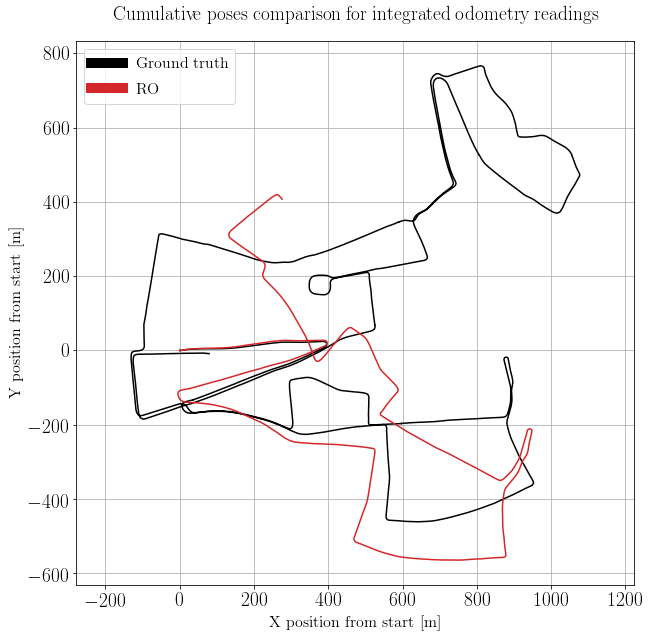

In [17]:
# get INS poses
INS_poses = []
pose = np.identity(4)
for i in range(len(INS_se3s)):
    pose = pose * INS_se3s[i]
    INS_poses.append(pose)

# get x,y coords
x_INS = [pose[0, 3] for pose in INS_poses]
y_INS = [pose[1, 3] for pose in INS_poses]
# downsample INS for figure rendering
x_INS_lite = x_INS[::10]
y_INS_lite = y_INS[::10]

# get RO poses
RO_poses = []
pose = np.identity(4)
for i in range(len(RO_se3s)):
    pose = pose * RO_se3s[i]
    RO_poses.append(pose)

# get x,y coords
x_RO = [pose[0, 3] for pose in RO_poses]
y_RO = [pose[1, 3] for pose in RO_poses]


plt.figure(figsize=(10,10)) # was 15,15
plt.plot(x_INS_lite,y_INS_lite,'-',color=colour_ins,markersize=1);
plt.plot(x_RO,y_RO,'-',color=colour_ro,markersize=1);

plt.axis('equal');
plt.title('Cumulative poses comparison for integrated odometry readings');
plt.xlabel('X position from start [m]');
plt.ylabel('Y position from start [m]');
line1, = plt.plot([],[],color=colour_ins,label='Ground truth',linewidth=10.0)
line2, = plt.plot([],[],color=colour_ro,label='RO',linewidth=10.0)

# plt.xlim(150, 200)
# plt.ylim(0,20)

plt.legend(handles=[line1,line2],loc='best')
plt.savefig(dataset_path+"figs/filename_all_poses.pdf",bbox_inches='tight',pad_inches = 0)

NameError: name 'signal' is not defined

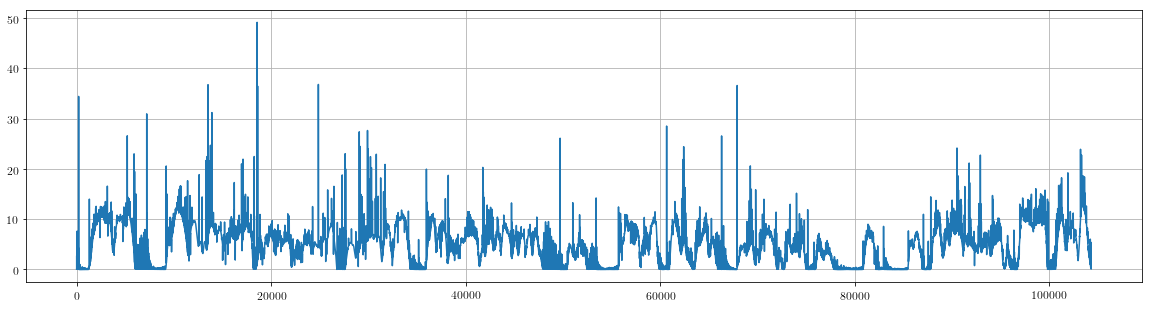

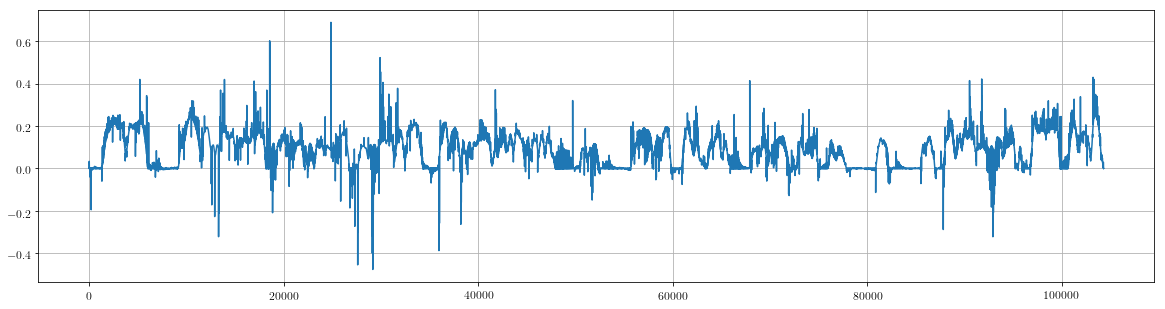

In [4]:
# get INS speeds
INS_speeds = []
INS_x_vals = []
INS_y_vals = []
filt_INS_se3s = []

# This is critical, otherwise we risk editing INS_se3s elements
for i in range(1,len(INS_se3s)):
    filt_INS_se3s.append((np.matrix(INS_se3s[i])))

deltatime_arr = []
for i in range(1,len(INS_timestamps)):
    INS_x_vals.append(INS_se3s[i][0,3])
    INS_y_vals.append(INS_se3s[i][1,3])
    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = INS_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    INS_speeds.append(speed)

plt.figure(figsize=(20,5))
plt.plot(INS_speeds);

plt.figure(figsize=(20,5))
plt.plot(INS_x_vals);
filt_INS_x_vals = signal.medfilt(INS_x_vals,5)
plt.plot(filt_INS_x_vals);
plt.xlim(20000,40000)

plt.figure(figsize=(20,5))
plt.plot(INS_y_vals);
filt_INS_y_vals = signal.medfilt(INS_y_vals,3)
plt.plot(filt_INS_y_vals);
plt.xlim(20000,40000)

filt_INS_speeds = []

for i in range(1,len(INS_timestamps)-1):
    # work out speed
    delta_time = (INS_timestamps[i] - INS_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    translation = [filt_INS_x_vals[i],filt_INS_y_vals[i]]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    filt_INS_speeds.append(speed)
    
plt.figure(figsize=(20,5))
plt.plot(INS_speeds);
plt.plot(filt_INS_speeds);
plt.xlim(20000,40000)


In [ ]:
INS_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in INS_se3s]
filt_INS_thetas = signal.medfilt(INS_thetas,5)
plt.figure(figsize=(20,5))
plt.plot(INS_thetas)
plt.plot(filt_INS_thetas)
plt.xlim(20000,40000)

In [ ]:
# Adjust se3s after filtering has been done
for i in range(len(filt_INS_se3s)):
    filt_INS_se3s[i][0,0] = np.cos(filt_INS_thetas[i])
    filt_INS_se3s[i][0,1] = -np.sin(filt_INS_thetas[i])
    filt_INS_se3s[i][1,0] = np.sin(filt_INS_thetas[i])
    filt_INS_se3s[i][1,1] = np.cos(filt_INS_thetas[i])


(20000, 40000)

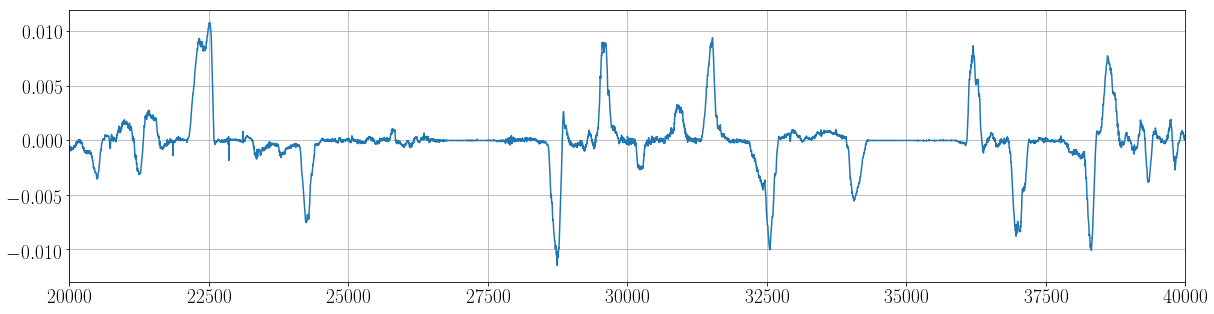

In [13]:
INS_thetas = [np.arctan2(x[1, 0], x[0, 0]) for x in filt_INS_se3s]
# filt_INS_thetas = signal.medfilt(INS_thetas,5)
plt.figure(figsize=(20,5))
plt.plot(INS_thetas)
# plt.plot(filt_INS_thetas)
plt.xlim(20000,40000)

(18000, 19000)

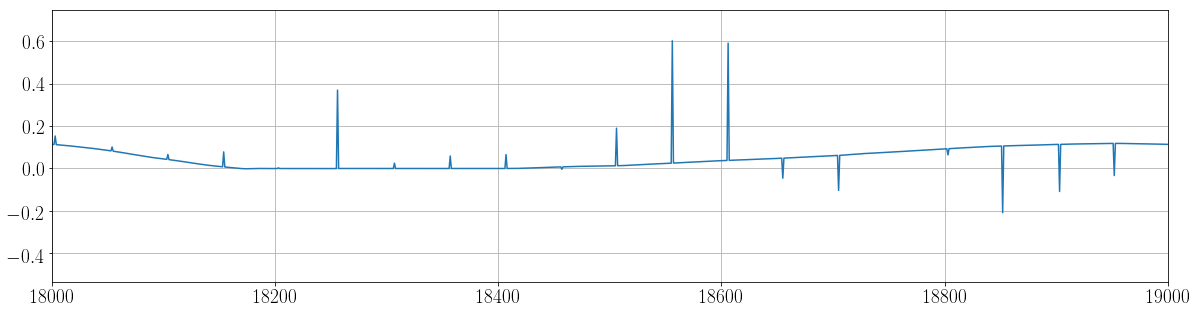

In [12]:
plt.figure(figsize=(20,5))
plt.plot(INS_x_vals)
plt.xlim(18000,19000)

(200, 250)

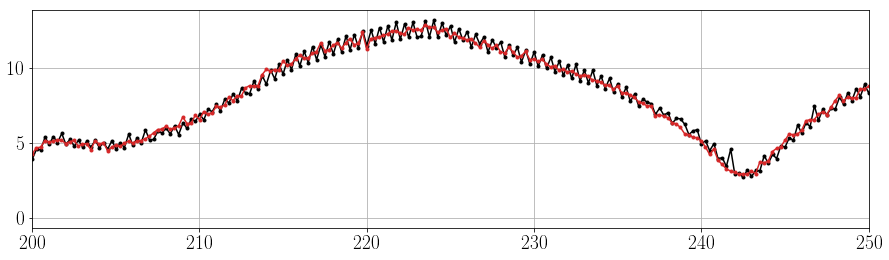

In [25]:


# get speeds
assert len(RO_se3s) == len(RO_timestamps)
RO_speeds = []
RO_TIMESTAMPS = []
deltatime_arr = []
for i in range(1,len(RO_timestamps)):
    # work out speed
    delta_time = (RO_timestamps[i] - RO_timestamps[i - 1]) / settings.TIMESTAMP_CONVERSION
    deltatime_arr.append(delta_time)
    se3 = RO_se3s[i]
    translation = se3[0:2, -1]
    incremental_distance = np.linalg.norm(translation)
    speed = incremental_distance / delta_time
    RO_speeds.append(speed)
    RO_TIMESTAMPS.append(RO_timestamps[i])

    
INS_seconds = [(timestamp - INS_timestamps[0]) / settings.TIMESTAMP_CONVERSION for timestamp in INS_timestamps]
RO_seconds = [(timestamp - RO_TIMESTAMPS[0]) / settings.TIMESTAMP_CONVERSION for timestamp in RO_TIMESTAMPS]

time_offset = (INS_timestamps[0] - RO_timestamps[0])/settings.TIMESTAMP_CONVERSION
# Do interpolation (accumulatation for now)
interp_INS_speed = []
interp_INS_seconds = []
distance = 0
temp_speed = 0
j = 0
for i in range(len(RO_timestamps)):
    while(INS_timestamps[j] < RO_timestamps[i] and j < len(INS_speeds)):
        distance += INS_speeds[j]*(INS_timestamps[j]-INS_timestamps[j-1])
        j+=1

    if(RO_timestamps[i] < (INS_timestamps[0]+(RO_timestamps[1]-RO_timestamps[0]))):
        distance = 0
    
    temp_speed = distance/(RO_timestamps[i]-RO_timestamps[i-1])
    interp_INS_speed.append(temp_speed)
    interp_INS_seconds.append(((INS_timestamps[j] - INS_timestamps[0]) / settings.TIMESTAMP_CONVERSION) + time_offset)
    distance = 0
    
plt.figure(figsize=(15,4))
plt.plot(interp_INS_seconds,interp_INS_speed,'.-',color=colour_ins)
plt.plot(RO_seconds,RO_speeds,'.-',color=colour_ro);
plt.xlim(200,250)